# Introduction  

This notebook walks through the code I used to visualize my analysis of Isaiah Thomas's 2016-17 NBA regular season and Kyrie Irving's 2017-18 NBA regular season. This was done using Python,the Pandas data analysis library, and matplotlib. All of the data used in this notebook were collected from [basketball-reference](https://www.basketball-reference.com/). This notebook **only** shows how I generated the graphs used in my report. You can see my full analysis of these figures [here](https://www.razeenahmad.com/thomas-irving-trade-analysis).

# Gathering and Formatting DataFrames

First, I import the necessary libraries and modules, so I can analyze and plot the gathered data.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import norm

Next, I read in the data from local csv files and initialize DataFrames. All csv file data was obtained from [basketball-reference](https://www.basketball-reference.com/). 

In [2]:
#reading in data from csv files
it_reg_szn = pd.read_csv('Data/IT_16-17_reg_szn_game_stats.csv')
it_adv = pd.read_csv('Data/IT_16-17_reg_szn_adv_stats.csv')
ki_reg_szn = pd.read_csv('Data/KI_17-18_reg_szn_game_stats.csv')
ki_adv = pd.read_csv('Data/KI_17-18_reg_szn_adv_stats.csv')
celtics1617_reg_szn = pd.read_csv('Data/Celtics_16-17_reg_szn_results.csv')
celtics1718_reg_szn = pd.read_csv('Data/Celtics_17-18_reg_szn_results.csv')
nba1617_standings = pd.read_csv('Data/nba_standings_1617.csv')
nba1718_standings = pd.read_csv('Data/nba_standings_1718.csv')

In this section, DataFrames holding regular season statistics for both players (Isaiah Thomas and Kyrie Irving) are formatted to ensure they have the correct column labels and row indices. This includes renaming column labels and dropping some columns entirely. I also cast the DataFrame's entries to floats, so I can analyze the data using numeric functions later on. 

In [3]:
#function to formatting regular season statistics DataFrames
def format_reg_stats(df):
    df.rename(columns={'_1':'Result', 'G':'Game Played', 'Rk':'Game Number'}, inplace = True)#rename columns
    df.set_index('Game Number', inplace = True) #set row indices
    #drop extra columns
    df.drop(['Tm','Column1','GS','Date','Age','Result','MP','Opp'], axis = 1, inplace = True)

    df = df.apply(pd.to_numeric, axis = 1, errors = 'coerce')#cast entries to floats
    return df
    
#format regular season statistics DataFrames for both players using above function
it_reg_szn = format_reg_stats(it_reg_szn)
ki_reg_szn = format_reg_stats(ki_reg_szn)


#function to format regular season advanced statistics DataFrames
def format_adv_stats(df):
    df.drop(["Column2", "Column3", "Column4", "Column5", "Column6", "Column7", "Column8", "Column9", 
             "Column10"], axis = 1, inplace = True) #drop extra columns
    df.columns = df.iloc[0] #set column labels
    df.drop([0], inplace = True) #drop extra row

    df = df.apply(pd.to_numeric, axis = 1, errors = 'coerce') #cast entries to float

    df.rename(columns={'Rk':'Game Number'}, inplace = True) #rename column
    df = df.set_index('Game Number') #set row indices
    return df

    
#format advanced statistics DataFrames for both players using above function
it_adv = format_adv_stats(it_adv)
ki_adv = format_adv_stats(ki_adv)

Next, I format the DataFrames holding data on the Boston Celtics regular season schedule. This data is not used extensively in my report. However, I used this section to learn and practice new Pandas formatting techniques to use in future reports. Here, I apply a function to a DataFrame column to rewrite its entries into more intuitive string values.

In [4]:
#function to write Home/Away column entries
def Home_Or_Away(s):
    if (isinstance(s, float) and math.isnan(s)):
        return "Home"
    else:
        return "Away"

#function to format regular season schedule DataFrames
def format_reg_szn(df):
    df.drop(["Column3","Column4","Column5","Column9","Column10","Column11","Column12",
            "Column13","Column14","Column15"], axis = 1, inplace = True) #drop extra columns
    df.columns = df.iloc[0] #set column labels
    df.drop([0], inplace = True) #drop extra row

    #fill "NaN" column headers with 'Location' and 'Result'
    col_names = pd.Series(df.columns)
    col_names = col_names.fillna('_' + (col_names.groupby(col_names.isnull()).cumcount() + 1).astype(str)) 
    df.columns = col_names
    #rename to 'Location' and 'Result'
    df.rename(columns={'G':'Game Number', '_1':'Location','_2':'Result'}, inplace = True)

    df.set_index('Game Number', inplace = True) #set row indices
    #rewrite 'Location' column entries by applying function to that column 
    df['Location'] = df['Location'].apply(lambda x: Home_Or_Away(x))

    #cast data types
    df['Location'] = df['Location'].astype("string")
    df['Opponent'] = df['Opponent'].astype("string")
    df['Result'] = df['Result'].astype("string")
    df['Date'] = pd.to_datetime(df['Date'])
    return df

    
    

#formatting Celtics 2016-17 and 2017-18 regular season schedule DataFrames
celtics1617_reg_szn = format_reg_szn(celtics1617_reg_szn)
celtics1718_reg_szn = format_reg_szn(celtics1718_reg_szn)

In the final block of this section, I format the DataFrames holding leaguewide standings for each season. Here, I use a pair of functions to convert a string describing a team's record into two separate strings- wins and losses. These strings are then cast to floats and appended to the DataFrame to form two new numeric column holding wins and losses numbers.

In [5]:
#functions to pull out string of wins/losses from string in WW-LL string format
def Get_Wins(s):
    if(s[2] == '-'):
        return s[:2]
    else:
        return s[:1]
def Get_Losses(s):
    if(s[2] == '-'):
        return s[3:]
    else:
        return s[2:]

#function to format NBA standings DataFrames
def format_standings(df):
    df.columns = df.iloc[1] #set column labels
    df.drop([0,1], inplace = True) #drop extra rows
    df.drop(df.columns.to_series()["E":"Apr"], axis=1, inplace = True) #drop multiple columns
    df.rename(columns={'Rk': 'Rank'}, inplace = True) #rename column
    df.set_index('Team', inplace = True) #set row indices
    
    #separate out wins/losses in columns of NBA standings DataFrame and cast all entries to floats
    numwins = df['Overall'].apply(lambda x: Get_Wins(x)) #get Overall wins
    numlosses = df['Overall'].apply(lambda x: Get_Losses(x)) #get Overall losses
    df['Overall Wins'] = numwins.astype(float) #convert wins string to float
    df['Overall Losses'] = numlosses.astype(float) #convert losses string to float
    
    #repeat for home record
    numwins = df['Home'].apply(lambda x: Get_Wins(x)) 
    numlosses = df['Home'].apply(lambda x: Get_Losses(x))
    df['Home Wins'] = numwins.astype(float)
    df['Home Losses'] = numlosses.astype(float)
    
    #repeat for road record
    numwins = df['Road'].apply(lambda x: Get_Wins(x)) 
    numlosses = df['Road'].apply(lambda x: Get_Losses(x))
    
    #cast data types, drop columns
    df['Road Wins'] = numwins.astype(float)
    df['Road Losses'] = numlosses.astype(float)
    df['Rank'] = df['Rank'].astype(float) #cast 'Rank' column to float
    df.drop(["Overall", "Home", "Road"], axis = 1, inplace = True) #drop string columns
    return df
    

#formatting 2016-17 and 2017-18 NBA standings DataFrames
nba1617_standings = format_standings(nba1617_standings)
nba1718_standings = format_standings(nba1718_standings)

# Generating Data Visuals

In the rest of this notebook, I use the formatted DataFrames to plot various metrics and figures comparing Isaiah Thomas's 2016-17 regular season and Kyrie Irving's 2017-18 regular season. These visuals are contextualized and explained in my report, based on certain evaluation criteria.  

First, I generate a simple boxplot that compares Isaiah Thomas's and Kyrie Irving's regular season scoring.

Text(0.5, 0, 'Points Per Game')

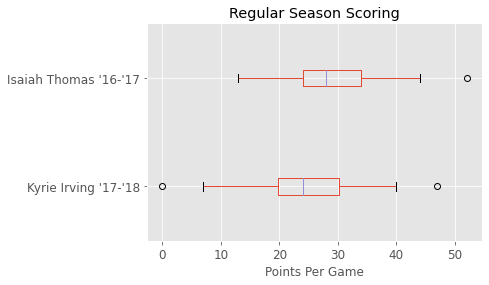

In [6]:
plt.style.use('ggplot') #establish color scheme for plots

#combine both players' scoring data into one data frame
reg_szn_pts = pd.concat([ki_reg_szn['PTS'], it_reg_szn['PTS']], axis = 1) 
reg_szn_pts.columns = ["Kyrie Irving '17-'18", "Isaiah Thomas '16-'17"] #set column labels

#graph both sets of data as horizontal boxplots
reg_szn_pts_plot = reg_szn_pts.plot(kind="box", fontsize = 12, vert= False, 
                                    title = "Regular Season Scoring")
reg_szn_pts_plot.set_xlabel("Points Per Game", fontsize = 12) #set x axis label

Next, we graph a normal distribution of both sets of scoring data. This is used in my report to calculate and compare basic statistical figures. 

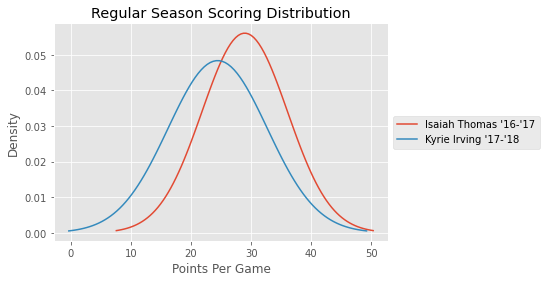

In [7]:
#plot Isaiah Thomas's scoring distribution
mu = reg_szn_pts["Isaiah Thomas '16-'17"].mean() #get distribution mean
sigma = reg_szn_pts["Isaiah Thomas '16-'17"].std() #get distribution standard deviation
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100) #set x axis scale
plt.plot(x, norm.pdf(x, mu, sigma), label = "Isaiah Thomas '16-'17") #plot

#Repeat above with Kyrie Irving's scoring data
mu = reg_szn_pts["Kyrie Irving '17-'18"].mean()
sigma = reg_szn_pts["Kyrie Irving '17-'18"].std()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, norm.pdf(x, mu, sigma), label = "Kyrie Irving '17-'18")

#generate plot
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) #legend location
plt.title("Regular Season Scoring Distribution")
plt.xlabel("Points Per Game")
plt.ylabel("Density")
plt.show()

Here, I graph the players' average field goal attempts per game and field goal percentage over the course of their respective seasons.

Text(0.5, 0, '')

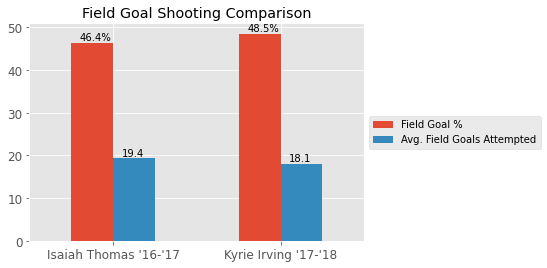

In [8]:
#Gather Isaiah Thomas's field goal % and field goal attempts figures from DataFrames
it_fgp = it_reg_szn['FG%'].mean() * 100
it_fgp = round(it_fgp, 1) #round to 1 decimal point
it_fga = it_reg_szn['FGA'].mean()
it_fga = round(it_fga, 1)

#Repeat for Kyrie Irving
ki_fgp = ki_reg_szn['FG%'].mean() * 100
ki_fgp = round(ki_fgp, 1)
ki_fga = ki_reg_szn['FGA'].mean()
ki_fga = round(ki_fga, 1)

#Combine data gathered above into a single DataFrame
fg_comp = pd.DataFrame(columns = ["Player","Field Goal %", "Avg. Field Goals Attempted"])
fg_comp.loc[0] = ["Isaiah Thomas '16-'17", it_fgp, it_fga]
fg_comp.loc[1] = ["Kyrie Irving '17-'18", ki_fgp, ki_fga]
fg_comp = fg_comp.set_index('Player')

#plot field goal data from DataFrame created above
fg_comp_plot = fg_comp.plot(kind = "bar", title = "Field Goal Shooting Comparison", rot = 0, 
                            fontsize = 12)
#add values on bars
for bar in fg_comp_plot.patches: 
    #if bar corresponds to Field Goal %, want to add '%' to its value label
    if((bar.get_height() > 20)):
        fg_comp_plot.annotate(str(bar.get_height()) + "%", (bar.get_x() + 0.05, bar.get_height() + 0.5))
    else:
        fg_comp_plot.annotate(str(bar.get_height()), (bar.get_x() + 0.05, bar.get_height() + 0.5))
        
fg_comp_plot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
fg_comp_plot.set_xlabel("")

In this block, we plot the players' average true shooting percentage to supplement our shooting efficiency figures (this is explained in more depth in my report).

Text(0, 0.5, 'True Shooting %')

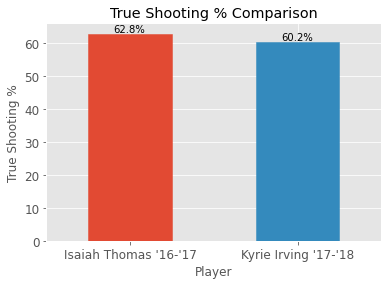

In [9]:
#gather true shooting figures for Isaiah Thomas
it_ts = it_adv['TS%'].mean()*100
it_ts = round(it_ts, 1) #round to 1 decimal point

#gather figures for Kyrie Irving
ki_ts = ki_adv['TS%'].mean()*100
ki_ts = round(ki_ts, 1)

#combine true shooting figures into single DataFrame
ts_comp = pd.DataFrame(columns = ["Player", "True Shooting %"])
ts_comp.loc[0] = ["Isaiah Thomas '16-'17", it_ts]
ts_comp.loc[1] = ["Kyrie Irving '17-'18", ki_ts]
ts_comp = ts_comp.set_index('Player')

#plot true shooting figures
#remove legend and make sure x-axis labels are horizontal
ts_comp_plot = ts_comp.plot(kind = "bar", title = "True Shooting % Comparison", rot = 0, 
                            fontsize = 12, legend = False)
#loop to add true shooting values onto bars and add different colored bars
for i, bar in enumerate(ts_comp_plot.patches):
    ts_comp_plot.annotate(str(bar.get_height()) + "%", (bar.get_x() + 0.15, bar.get_height() + 0.5))
    if (i == 0):
        bar.set_color('C0')
    else:
        bar.set_color('C1')
ts_comp_plot.set_xlabel("Player")
ts_comp_plot.set_ylabel("True Shooting %")

In these next two code blocks, I generate a boxplot and a normal distribution curve comparing Isaiah Thomas and Kyrie Irving's assists per game. 

Text(0, 0.5, 'Player')

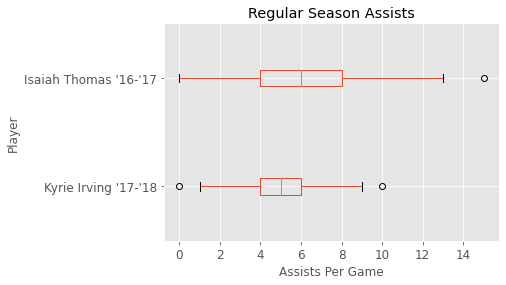

In [10]:
#Combine assists per game figures into single DataFrame
#First, we combine assists per game data from reg_szn DataFrames
reg_szn_ast = pd.concat([ki_reg_szn['AST'], it_reg_szn['AST']], axis = 1)
reg_szn_ast.columns = ["Kyrie Irving '17-'18", "Isaiah Thomas '16-'17"] #set column labels

#generate horizontal boxplot of assists per game
reg_szn_ast_plot = reg_szn_ast.plot(kind="box", fontsize = 12, vert= False, 
                                    title = "Regular Season Assists")
reg_szn_ast_plot.set_xlabel("Assists Per Game", fontsize = 12)
reg_szn_ast_plot.set_ylabel("Player", fontsize = 12)

Like I did for scoring, I plot a normal distribution of each player's assists per game below.

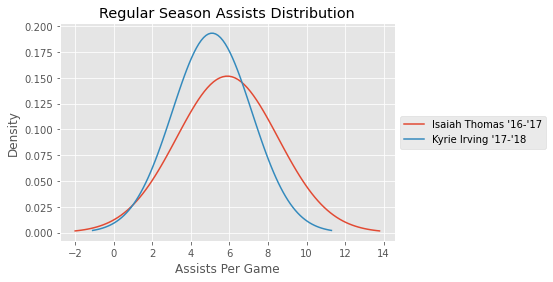

In [11]:
#plot normal distribution for Isaiah Thomas assists per game
mu = reg_szn_ast["Isaiah Thomas '16-'17"].mean() # calculate distribution mean 
sigma = reg_szn_ast["Isaiah Thomas '16-'17"].std() # calculate distribution standard deviation
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100) # set x-axis scale
plt.plot(x, norm.pdf(x, mu, sigma), label = "Isaiah Thomas '16-'17") # plot Isaiah Thomas distribution

#repeat for Kyrie Irving assists per game
mu = reg_szn_ast["Kyrie Irving '17-'18"].mean()
sigma = reg_szn_ast["Kyrie Irving '17-'18"].std()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, norm.pdf(x, mu, sigma), label = "Kyrie Irving '17-'18")

#set plot elements
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title("Regular Season Assists Distribution")
plt.xlabel("Assists Per Game")
plt.ylabel("Density")
plt.show()

Next, we calculate additional metrics related to how each player contributes to their team's offense. Assist percentage and usage rate can be calculated from our collected data, but offensive win shares (OWS) cannot. For this reason, OWS values are hard coded in from [basketball-reference](https://www.basketball-reference.com/).

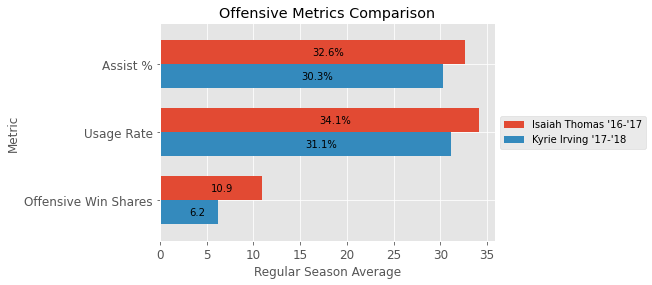

In [12]:
#gather assist %, usage rate, and offensive win shares for Isaiah Thomas
it_astp = it_adv['AST%'].mean()
it_astp = round(it_astp, 1)
it_usg = it_adv['USG%'].mean()
it_usg = round(it_usg, 1)
it_ows = 10.9

#gather figures for Kyrie Irving
ki_astp = ki_adv['AST%'].mean()
ki_astp = round(ki_astp, 1)
ki_usg = ki_adv['USG%'].mean()
ki_usg = round(ki_usg, 1)
ki_ows = 6.2

#combine figures into single DataFrame
ast_met_comp = pd.DataFrame(columns = ["Player", "Assist %", "Usage Rate", "Offensive Win Shares"])
ast_met_comp.loc[0] = ["Isaiah Thomas '16-'17", it_astp, it_usg, it_ows]
ast_met_comp.loc[1] = ["Kyrie Irving '17-'18", ki_astp, ki_usg, ki_ows]
ast_met_comp = ast_met_comp.set_index('Player')
#transpose to make horizontal bar plot grouped by metric and not player
ast_met_comp = ast_met_comp.transpose()

#plot figures as a horizontal bar plot
ast_met_bar_plot = ast_met_comp.plot(kind = "barh", title = "Offensive Metrics Comparison", rot = 0, 
                                     fontsize = 12, width = 0.7)
ast_met_bar_plot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ast_met_bar_plot.set_xlabel("Regular Season Average")
ast_met_bar_plot.set_ylabel("Metric")

#add values onto bars
for bar in ast_met_bar_plot.patches:
    left, bottom, width, height = bar.get_bbox().bounds
    #if bar length is >15, it is a percentage, so we want to add '%' to its value label.
    if(bar.get_width() > 15):
        ast_met_bar_plot.annotate(str(bar.get_width()) + "%", xy=(left+width/2, bottom+height/2), 
                                  va = 'center')
    else:
        ast_met_bar_plot.annotate(str(bar.get_width()), xy=(left+width/2, bottom+height/2), 
                                  va = 'center')

plt.gca().invert_yaxis() #reverse order of bars so that they match with the legend order 

Next, we generate a pie chart for each player's contribution as a proportion of their starting lineups cumulative VORP metric. These measurements are not available in our collected data and consequently, are hard coded in from [basketball-reference](https://www.basketball-reference.com/).

Text(0, 0.5, '')

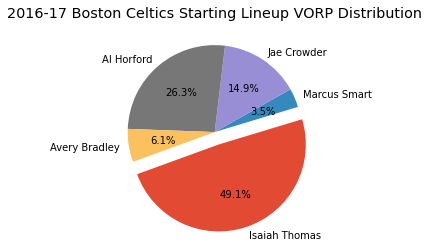

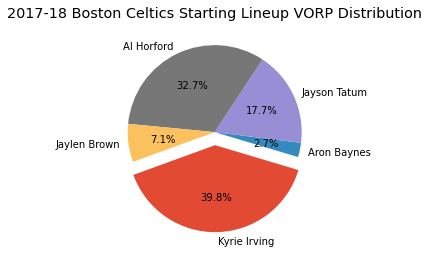

In [13]:
#Create DataFrames with vorp figures for Isaiah Thomas's teammates
it_team = pd.DataFrame(columns = ["Player", "VORP"])
it_team.loc[0] = ["Isaiah Thomas", 5.6]
it_team.loc[1] = ["Marcus Smart", 0.4]
it_team.loc[2] = ["Jae Crowder", 1.7]
it_team.loc[3] = ["Al Horford", 3.0]
it_team.loc[4] = ["Avery Bradley", 0.7]
it_team = it_team.set_index('Player') #set row indices

#repeat for Kyrie Irving's teammates
ki_team = pd.DataFrame(columns = ["Player", "VORP"])
ki_team.loc[0] = ["Kyrie Irving", 4.5]
ki_team.loc[1] = ["Aron Baynes", 0.3]
ki_team.loc[2] = ["Jayson Tatum", 2.0]
ki_team.loc[3] = ["Al Horford", 3.7]
ki_team.loc[4] = ["Jaylen Brown", 0.8]
ki_team = ki_team.set_index('Player')

#plot pie chart of VORP figures for Isaiah Thomas's team
#'autopct' labes pie slices with their respective percentage of the entire pie
#'explode' separates slices from pie
#'startangle' rotates entire pie by specified degree
it_team_plot = it_team.plot(kind = "pie", y = "VORP",autopct='%1.1f%%',
                            title = "2016-17 Boston Celtics Starting Lineup VORP Distribution", 
                            legend = False,explode = (0.15,0,0,0,0), startangle = 200)
it_team_plot.set_ylabel("")

#plot pie chart of VORP figures for Kyrie Irving's team
ki_team_plot = ki_team.plot(kind = "pie", y = "VORP",autopct='%1.1f%%', 
                            title = "2017-18 Boston Celtics Starting Lineup VORP Distribution", 
                            legend = False, explode = (0.15,0,0,0,0), startangle = 200)

ki_team_plot.set_ylabel("")

In these next two sections, I filter out and visualize each player's data when playing against the top 10 teams in the NBA. These rankings are purely based off of opponents' regular season record.  

As given, the player statistics DataFrames do not specify the opposing team or their regular season ranking. However, data in other DataFrames (Celtics regular season results and NBA standings) can be used to pull out this information. This information is then used to create a new DataFrame only containing player statistics against top 10 teams. This process is shown below. 

In [14]:
# Data obtained from the regular season DataFrames will be in the same order as the player 
#  statistics DataFrames. 
# We use the regular season DataFrames to derive opponent rankings from the corresponding NBA 
#  Standings DataFrame.
# Because these rankings will be in the same order, they can be easily appended to the 
#  player statistics DataFrames, allowing me to filter the data based on opponent ranking


#function to generate a list of matchup rankings to append onto each player's statistics DataFrames
def get_rankings(tm_schedule_df, lg_standings_df):
    #Generate a list of matchup rankings based on the team's regular season schedule
    team_ranks = []
    #iterate through opponent column of regular season schedule DataFrame
    for i, team in tm_schedule_df['Opponent'].items():
        #obtain ranking of opponent based on corresponding NBA standings DataFrame
        r = lg_standings_df.loc[team]['Rank']
        team_ranks.append(r) #append this ranking to our list
    return team_ranks
    

#get opponent rankings for Isaiah Thomas's schedule
it_opp_ranks = get_rankings(celtics1617_reg_szn, nba1617_standings)
#add these rankings as a new column in our Isaiah Thomas statistics DataFrames
it_adv['Opp. Rank'] = it_opp_ranks
it_reg_szn['Opp. Rank'] = it_opp_ranks

#get opponent rankings for Kyrie Irving's schedule
ki_opp_ranks = get_rankings(celtics1718_reg_szn, nba1718_standings)
#add these rankings as a new column in our Kyrie Irving statistics DataFrames
ki_adv['Opp. Rank'] = ki_opp_ranks
ki_reg_szn['Opp. Rank'] = ki_opp_ranks



#Pull out Isaiah Thomas's data against top 10 ranked teams into a new DataFrame
it_t10_adv = it_adv.loc[(it_adv['Opp. Rank'] <= 10)]
it_t10_reg = it_reg_szn.loc[(it_reg_szn['Opp. Rank'] <= 10)]

#repeat for Kyrie Irving
ki_t10_adv = ki_adv.loc[(ki_adv['Opp. Rank'] <= 10)]
ki_t10_reg = ki_reg_szn.loc[(ki_reg_szn['Opp. Rank'] <= 10)]

After filtering out data against top 10 teams, we graph various offensive metrics to compare the players' performance against top 10 teams.

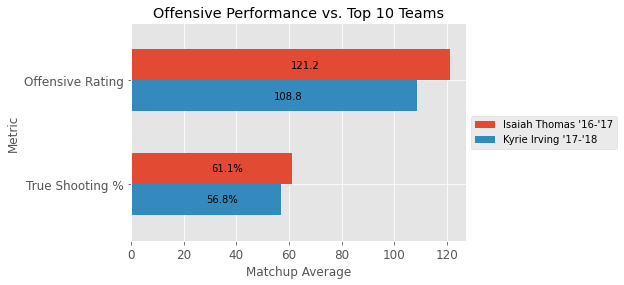

In [15]:
#Pull out Isaiah Thomas's average offensive rating and true shooting % against top 10 teams
it_avg_t10_ortg = it_t10_adv['ORtg'].mean()
it_avg_t10_ortg = round(it_avg_t10_ortg,1) #round to 1 decimal point
it_avg_t10_ts = it_t10_adv['TS%'].mean() * 100
it_avg_t10_ts = round(it_avg_t10_ts,1)

#repeat for Kyrie Irving
ki_avg_t10_ortg = ki_t10_adv['ORtg'].mean()
ki_avg_t10_ortg = round(ki_avg_t10_ortg,1)
ki_avg_t10_ts = ki_t10_adv['TS%'].mean() * 100
ki_avg_t10_ts = round(ki_avg_t10_ts, 1)

#combine their figures into a single DataFrame
top10_metrics = pd.DataFrame(columns = ["Player", "Offensive Rating", "True Shooting %"])
top10_metrics.loc[0] = ["Isaiah Thomas '16-'17", it_avg_t10_ortg, it_avg_t10_ts]
top10_metrics.loc[1] = ["Kyrie Irving '17-'18", ki_avg_t10_ortg, ki_avg_t10_ts]
top10_metrics = top10_metrics.set_index('Player')
top10_metrics = top10_metrics.transpose() #transpose to group by metric, not player

#Generate a horizonatal bar plot for these figures
top10_metrics_plot = top10_metrics.plot(kind = "barh", 
                                        title = "Offensive Performance vs. Top 10 Teams", 
                                        rot = 0, fontsize = 12, width = 0.6)
top10_metrics_plot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
top10_metrics_plot.set_xlabel("Matchup Average")
top10_metrics_plot.set_ylabel("Metric")
plt.gca().invert_yaxis() #reverse order so that legend order and bar order match

#add value annotations to each bar
for bar in top10_metrics_plot.patches: 
    left, bottom, width, height = bar.get_bbox().bounds
    #if reading <100, bar is for true shooting % and want '%' added to annotation.
    if((bar.get_width() < 100)): 
        top10_metrics_plot.annotate(str(bar.get_width()) + "%", xy=(left+width/2, bottom+height/2), 
                                    va = 'center')
    else:
        top10_metrics_plot.annotate(str(bar.get_width()), xy=(left+width/2, bottom+height/2), 
                                    va = 'center')

In this final group of graphs, I compare Isaiah Thomas and Kyrie Irving's statistical output to historically great NBA seasons by comparable players. The data used in these graphs are hard coded in from [basketball-reference](https://www.basketball-reference.com/). 

I start by gathering these figures into a single DataFrame.

In [16]:
# I compare Isaiah Thomas and Kyrie Irving's regular season to Stephen Curry's 2015-16 MVP Season,
#  Allen Iverson's 2000-01 MVP Season, Kobe Bryant's 2007-08 MVP Season, and 
#  James Harden's 2017-18 MVP Season

#Gather Player Efficiency Rating figures for each player
it_per = 26.5
ki_per = 25.0
cur_per = 31.5
ai_per = 24.0
kb_per = 24.2
jh_per = 29.8

#Gather Offensive Win Shares figures
it_ows = 10.9
ki_ows = 6.3
cur_ows = 13.8
ai_ows = 7.3
kb_ows = 9.5
jh_ows = 11.6

#Gather true shooting % figures
it_ts = 62.8
ki_ts = 60.2
cur_ts = 66.9
ai_ts = 51.8
kb_ts = 57.6
jh_ts = 61.9

#Gather points per game figures
it_pts = 28.9
ki_pts = 24.4
cur_pts = 30.1
ai_pts = 31.1
kb_pts = 28.3
jh_pts = 30.4

#Gather assists per game figures
it_ast = 5.9
ki_ast = 5.1
cur_ast = 6.7
ai_ast = 4.6
kb_ast = 5.4
jh_ast = 8.8

#Gather all figures into single DataFrame
hist_cntxt = pd.DataFrame(columns = ["Player", "Player Efficiency Rating", "Offensive Win Shares", 
                                     "True Shooting %", "Points Per Game", "Assists Per Game"])
hist_cntxt.loc[0] = ["Isaiah Thomas '16-'17", it_per, it_ows, it_ts, it_pts, it_ast]
hist_cntxt.loc[1] = ["Kyrie Irving '17-'18", ki_per, ki_ows, ki_ts, ki_pts, ki_ast]
hist_cntxt.loc[2] = ["Stephen Curry '15-'16", cur_per, cur_ows, cur_ts, cur_pts, cur_ast]
hist_cntxt.loc[3] = ["James Harden '17-'18", jh_per, jh_ows, jh_ts, jh_pts, jh_ast]
hist_cntxt.loc[4] = ["Kobe Bryant '07-'08", kb_per, kb_ows, kb_ts, kb_pts, kb_ast]
hist_cntxt.loc[5] = ["Allen Iverson '00-'01", ai_per, ai_ows, ai_ts, ai_pts, ai_ast]
hist_cntxt_idx = hist_cntxt.set_index('Player')

Next, I generate a scatterplot of Points Per Game vs. Assists Per Game for each player.

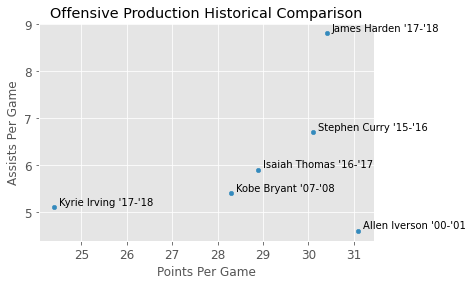

In [17]:
#Plot scatterplot of points per game vs. assists per game
hist_cmp_scatter_plot = hist_cntxt_idx.plot(kind = "scatter", 
                                            title = "Offensive Production Historical Comparison",
                                            x = "Points Per Game", y = "Assists Per Game", 
                                            fontsize = 12)
#label points with player they correspond to 
for label, v in hist_cntxt_idx.iterrows():
    hist_cmp_scatter_plot.annotate(label, (v['Points Per Game'] + 0.1,v['Assists Per Game']+0.05))

Next, I compare each player's Player Efficiency Rating and Offensive Win Shares through a horizontal bar chart.

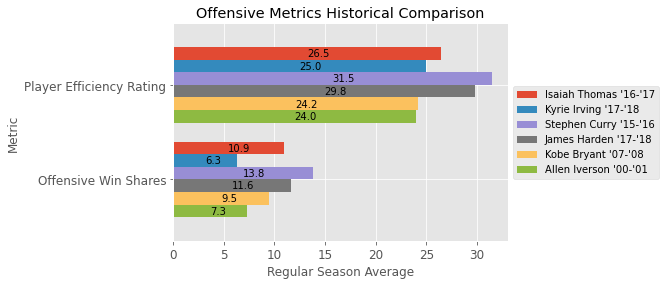

In [18]:
#transpose DataFrame to group figures by metric, not player
hist_cntxt_inv = hist_cntxt.transpose()
hist_cntxt_inv.columns = hist_cntxt_inv.iloc[0]
#drop extra columns
hist_cntxt_inv = hist_cntxt_inv.drop(['Player','True Shooting %', 'Points Per Game', 
                                      'Assists Per Game'])

#Generate horizontal bar plot
hist_cmp_bar_plot = hist_cntxt_inv.plot(kind = "barh", 
                                        title = "Offensive Metrics Historical Comparison", 
                                        rot = 0, fontsize = 12, width = 0.8)
hist_cmp_bar_plot.set_ylabel("Metric")
hist_cmp_bar_plot.set_xlabel("Regular Season Average")
hist_cmp_bar_plot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) #legend location

for bar in hist_cmp_bar_plot.patches: #add value annotations to each bar
    left, bottom, width, height = bar.get_bbox().bounds
    hist_cmp_bar_plot.annotate(str(bar.get_width()), xy=(left+width/2, bottom+height/2), va = 'center')

plt.gca().invert_yaxis() #reverse order of bars to match legend

Finally, I generate a separate horizontal bar chart comparing each player's true shooting percentage. This metric gets its own graph because it uses a much larger scale than the above metrics.

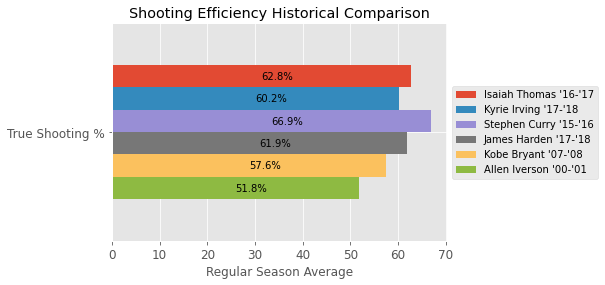

In [19]:
#transpose DataFrame to group by metric, not by player
hist_cntxt_ts = hist_cntxt.transpose()
hist_cntxt_ts.columns = hist_cntxt_ts.iloc[0]
#drop extra columns
hist_cntxt_ts = hist_cntxt_ts.drop(['Player','Points Per Game', 'Assists Per Game', 
                                    'Player Efficiency Rating', 'Offensive Win Shares'])

#Generate horizontal bar chart
hist_ts_bar_plot = hist_cntxt_ts.plot(kind = "barh", 
                                      title = "Shooting Efficiency Historical Comparison",
                                      rot = 0, fontsize = 12, width = 0.8)
hist_ts_bar_plot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) #legend location
hist_ts_bar_plot.set_xlabel("Regular Season Average")
for bar in hist_ts_bar_plot.patches: #add value annotations to each bar
    left, bottom, width, height = bar.get_bbox().bounds
    hist_ts_bar_plot.annotate(str(bar.get_width()) + "%", xy=(left+width/2, bottom+height/2), 
                              va = 'center')

plt.gca().invert_yaxis() #reverse order of bars to match legend

# Conclusion

This was my first time using pandas and matploblib extensively on any project. I learned a lot from generating these plots and look forward to building on the skills I learned here. To understand the full context behind these plots, make sure to check out my full report [here](https://www.razeenahmad.com/thomas-irving-trade-analysis). All feedback is greatly appreciated!